In [2]:
import numpy as np
import networkx as nx
import tqdm as tqdm
from collections import defaultdict
from kappa_tools import *
import sklearn as sk
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import dill 
dill.load_session("notebook_env.db")
import igraph as ig
import leidenalg
import tabulate

In [3]:
from networkx.generators.community import LFR_benchmark_graph
n = 8
tau1 = 2
tau2 = 1.5
mu = 0.5
G = LFR_benchmark_graph(
    n, tau1, tau2, mu, average_degree=3, min_community=3
)

Text(0.5, 1.0, 'Toy Network (no flow)')

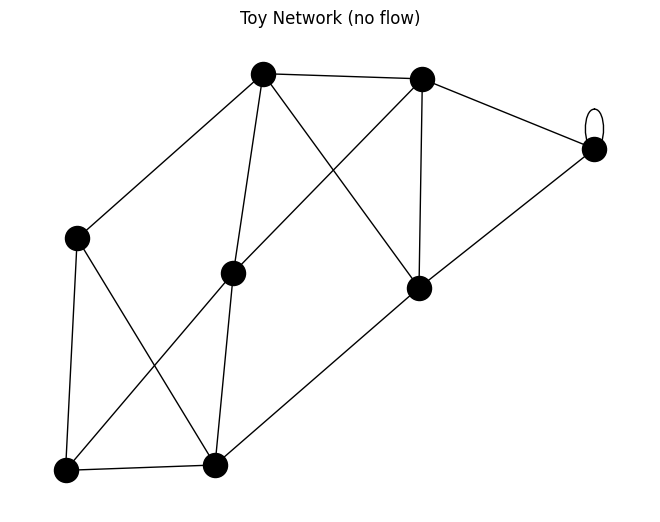

In [81]:
pos = nx.spring_layout(G) 
nx.draw(G,pos=pos,node_color="black",linewidths=1)
plt.title("Toy Network (no flow)")


In [5]:
x = nx.to_numpy_array(G)
x

array([[0., 1., 0., 0., 0., 1., 1., 1.],
       [1., 0., 1., 0., 1., 1., 0., 0.],
       [0., 1., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 0., 1., 0., 1.],
       [0., 1., 1., 0., 0., 0., 1., 1.],
       [1., 1., 0., 1., 0., 0., 0., 1.],
       [1., 0., 1., 0., 1., 0., 0., 0.],
       [1., 0., 0., 1., 1., 1., 0., 0.]])

In [19]:
st = """[0., 1., 0., 0., 0., 1., 1., 1.],
       [1., 0., 1., 0., 1., 1., 0., 0.],
       [0., 1., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 0., 1., 0., 1.],
       [0., 1., 1., 0., 0., 0., 1., 1.],
       [1., 1., 0., 1., 0., 0., 0., 1.],
       [1., 0., 1., 0., 1., 0., 0., 0.],
       [1., 0., 0., 1., 1., 1., 0., 0.] """

st = st.replace(".,", "&")
st = st.replace(".", "")
st = st.replace("[", "")
st = st.replace("]", r"\\")
print(st)

0& 1& 0& 0& 0& 1& 1& 1\\,
       1& 0& 1& 0& 1& 1& 0& 0\\,
       0& 1& 0& 0& 1& 0& 1& 0\\,
       0& 0& 0& 1& 0& 1& 0& 1\\,
       0& 1& 1& 0& 0& 0& 1& 1\\,
       1& 1& 0& 1& 0& 0& 0& 1\\,
       1& 0& 1& 0& 1& 0& 0& 0\\,
       1& 0& 0& 1& 1& 1& 0& 0\\ 


In [21]:
# Inducing flow
def flow_ij(G,i,j):
    return nx.flow.maximum_flow(G, i, j)[0]

def create_id(A):
    G = nx.from_numpy_array(A, parallel_edges=True,create_using=nx.DiGraph, edge_attr="capacity")
    m = A.shape[0]
    ind_i = ind_j = np.arange(0,m)
    Id = np.zeros([m,m])

    return Id

In [22]:
# matrix to numpy
def to_np(G:nx.multidigraph):
    edges = list(G.edges())#gets edges from generated network
    l = []
    [(l.append(x[0]), l.append(x[1])) for x in edges] #shape of matrix 
    m = max(l) +1
    A = np.zeros([m,m])

    for e in edges:
        A[e[0], e[1]] = 1


    return A

In [103]:
A = to_np(G)
D = nx.from_numpy_array(A, parallel_edges=True,create_using=nx.DiGraph, edge_attr="capacity")
I = np.zeros((A.shape[0], A.shape[0]))

for i in tqdm.tqdm(range(A.shape[0])):
    for j in range(A.shape[0]):
        if i != j:
            I[i,j] = flow_ij(D, i,j)
        else:
            I[i,j] = 0

100%|██████████| 8/8 [00:00<00:00, 44.89it/s]


In [109]:
L = G.to_directed()


In [139]:
I = I + I.T

In [140]:
st = """[0., 1., 1., 0., 1., 2., 2., 3.],
       [0., 0., 1., 0., 2., 1., 2., 2.],
       [0., 0., 0., 0., 1., 0., 2., 1.],
       [0., 0., 0., 0., 0., 1., 0., 2.],
       [0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.] """

st = st.replace(".,", "&")
st = st.replace(".", "")
st = st.replace("[", "")
st = st.replace("]", r"\\")
print(st)

0& 1& 1& 0& 1& 2& 2& 3\\,
       0& 0& 1& 0& 2& 1& 2& 2\\,
       0& 0& 0& 0& 1& 0& 2& 1\\,
       0& 0& 0& 0& 0& 1& 0& 2\\,
       0& 0& 0& 0& 0& 0& 1& 1\\,
       0& 0& 0& 0& 0& 0& 0& 1\\,
       0& 0& 0& 0& 0& 0& 0& 0\\,
       0& 0& 0& 0& 0& 0& 0& 0\\ 


In [141]:
pos = pos = nx.kamada_kawai_layout(G)

Text(0.5, 1.0, 'Toy Network with induced flow ')

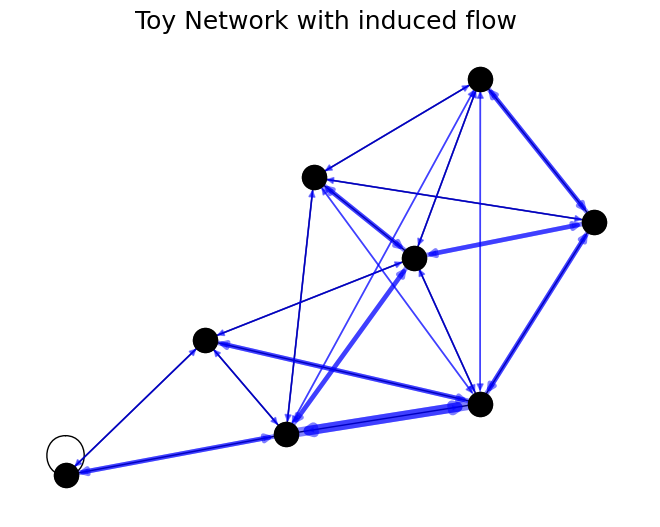

In [144]:
F = nx.from_numpy_array(I, create_using=nx.DiGraph)

edge_attrs = {}
for i in range(I.shape[0]):
    for j in range(I.shape[0]):
        if j in F[i]:
            x = I[i][j]
            edge_attrs[(i,j)] = {"weigth": 0.5+ 0.7*x**2}

edge_widths = [edge_attrs[key]["weigth"] for key in edge_attrs.keys()]

nx.draw(G,pos=pos,node_color="black")
nx.draw(F, pos=pos,node_color="black", width=edge_widths, edge_color="blue", alpha=0.5)
plt.title("Toy Network with induced flow ", fontsize=18)


Text(0.5, 1.0, 'Toy Network')

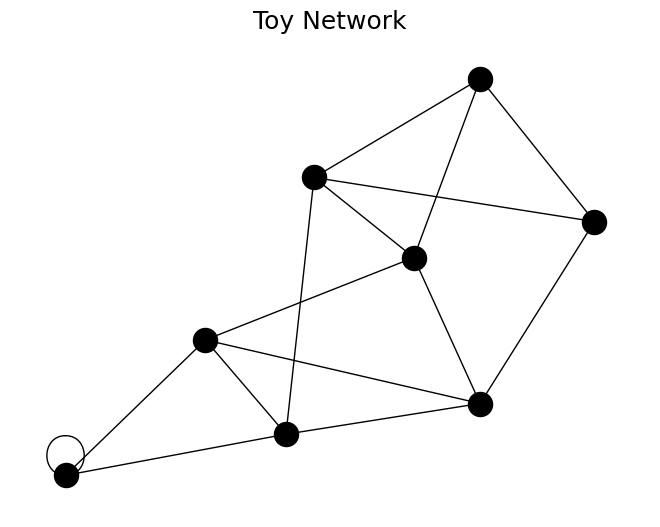

In [115]:
nx.draw(G,node_color="black",linewidths=1, pos=pos)
plt.title("Toy Network", fontsize=18)
